<h1>Convolutional Neural Network</h1>
<h2>Nathan Dilla & John Haviland</h2>

<h3>Problem Statement</h3>
In the current global health scenario, masks have emerged as a primary defense against respiratory diseases, especially COVID-19, given the lack of widespread immunization. Recognizing the importance of masks and their proper usage is vital for the public health and safety of everyone.

<h2>Dataset Overview</h2>
 <h3>Purpose</h3> The dataset is designed to enable the creation of a CNN model that can accurately detect whether an individual in an image is wearing a mask or not wearing a mask.
<h3>Total Images</h3> The dataset comprises 853 images that are categorized into two distinct classes.

<h3>Classes</h3> 

- With mask (with_mask)
- Without mask (no_mask)

<h3>Annotation</h3> Each image in the dataset is accompanied by bounding boxes provided in the PASCAL VOC format, ensuring precise model training by highlighting the region of interest.

By leveraging this dataset, our goal is to develop a CNN model that can effectively classify images based on mask usage, ensuring that safety protocols related to mask-wearing are adhered to.

---

In [1]:
import pathlib
import tensorflow as tf

'\ndataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\narchive = tf.keras.utils.get_file(origin=dataset_url, extract=True)\ndata_dir = pathlib.Path(archive).with_suffix(\'\')\n'

The easy way to split the image data is using the ‘split-folders’ package, which is a useful tool for automatically splitting a dataset into train, val and test sets based on the specified ratios for different subsets.

In [2]:
import splitfolders

splitfolders.ratio('./facemask', output="./mask_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))

(1) ‘splitfolders.ratio’: This is a function from the ‘split-folders’ package that performs the data splitting based on ratios.

(2) ‘./facemask’: This is the input path where the original dataset is located locally. In this case, the dataset is assumed to be in the “./facemask” folder.

(3) ‘output=”./mask_split_data”’: This is the output path where the split dataset will be saved. The ‘split-folders’ package library will create three subfolders inside the output directory: “train,” “val,” and “test,” which will contain the training, validation, and test sets, respectively.

(4) ‘seed=1337’: This is an optional parameter to set the random seed, which ensures reproducibility of the split. By providing a fixed seed value (1337 in this case), you’ll get the same split every time you run the code.

(5) ‘ratio=(0.7, 0.15, 0.15)’: This is the ratio for splitting the data into train, validation, and test sets. In this case, 70% of the data will be used for training, 15% for validation, and 15% for testing.

After executing this code, you will find the split dataset in the ‘“./mask_split_data” ‘ folder, with the appropriate distribution of images across the three subsets as specified by the ratios. This makes it easier to work with the data for training and evaluating the model separately, ensuring proper model evaluation and preventing data leakage between sets.



## Model process ##

### Step 1: Import libraries and load the dataset ###

In this step, we perform data preprocessing and augmentation. We use the ‘ImageDataGenerator’ from Keras to apply data augmentation techniques like rescaling, shear, zoom, and horizontal flip to increase the diversity of our training data. Data augmentation helps prevent overfitting and improves the generalization of the model.

Then we create data generators for the training, validation and test sets. The generators will load and preprocess images on-the-fly during training, which is memory-efficient.

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image

# Set the path to the dataset folder
data_path = "./mask_split_data"

# Create data generators for training and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)  

# Test the model on a few samples
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False
)

Found 641 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Found 139 images belonging to 2 classes.


### Step 2: Load the datasets and display sample images ###

In this updated code, we access the train_generator.filenames attribute to retrieve the filenames of the current batch of images. We also use the train_generator.class_indices mapping to convert the label (one-hot encoded) to its corresponding class name. The argmax() function is used to find the index of the maximum value in the one-hot encoded label, which corresponds to the class with the highest probability.

The images are displayed along with their respective filenames and training labels (class names). We use a batch size of 32, so it may show the first 32 images from the training set.

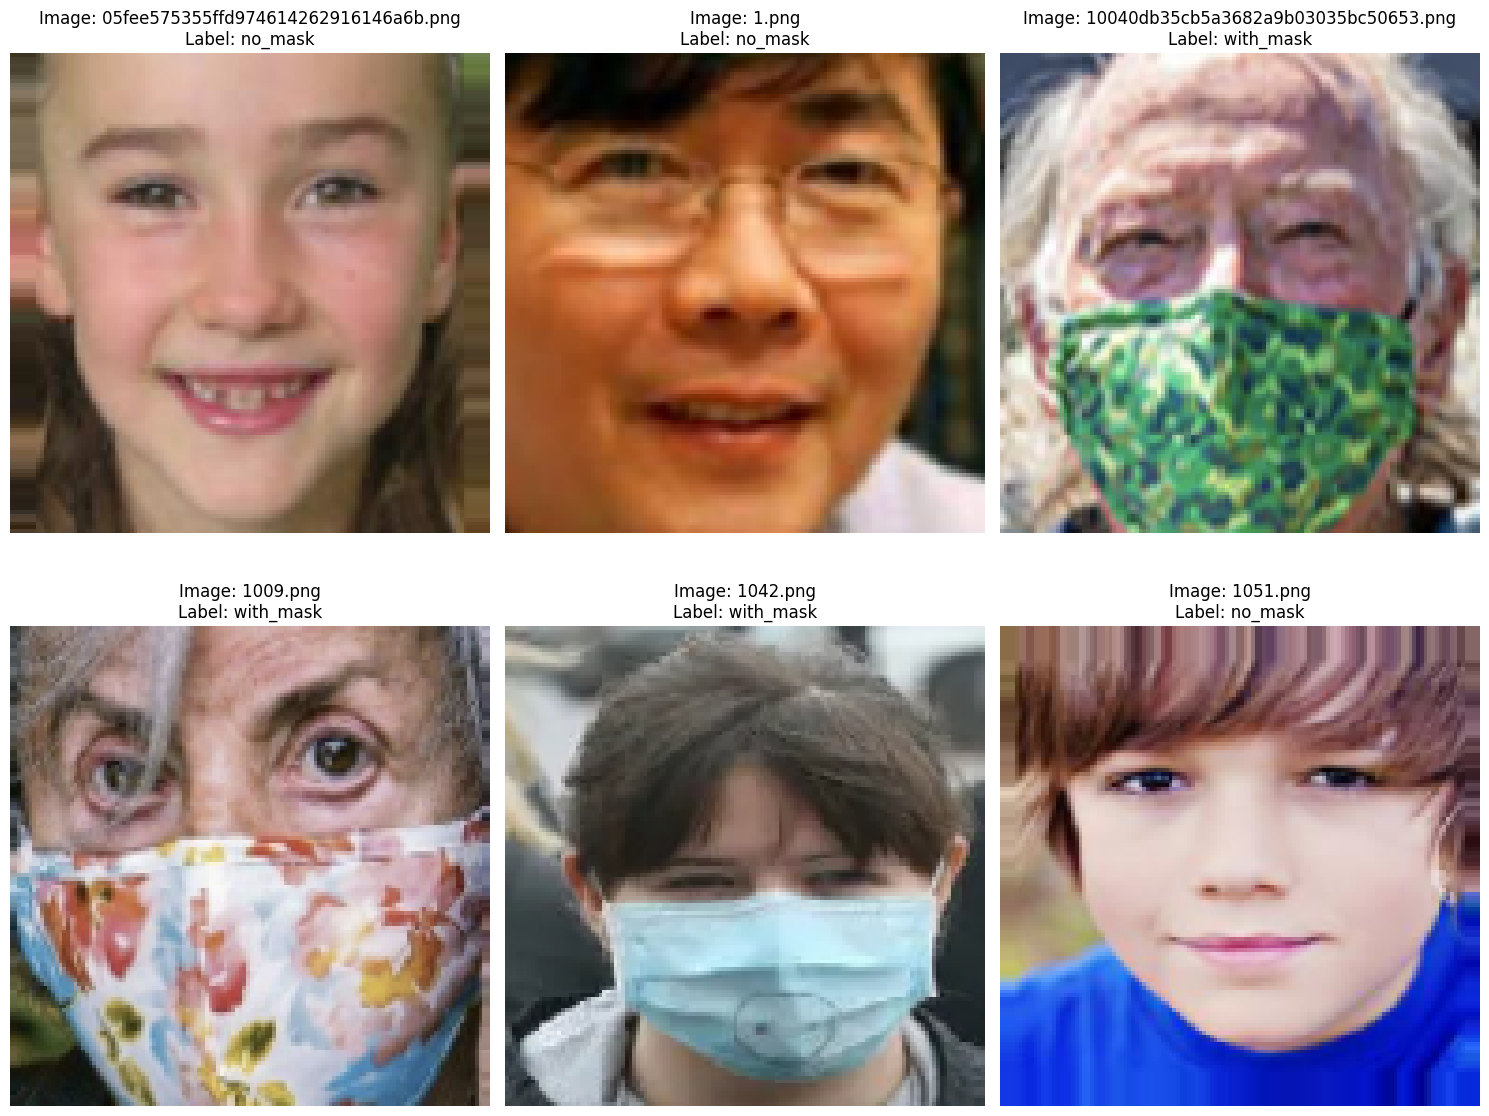

In [4]:
# Get the class indices mapping (class labels to class names)
class_indices = train_generator.class_indices

# Display 6 sample images from the training set along with their filenames and training labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, label = train_generator.next()
    img_filename = train_generator.filenames[train_generator.batch_index - 1]  # Get the filename of the current image
    img_class = list(class_indices.keys())[list(class_indices.values()).index(label[0].argmax())]  # Get the class name
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nLabel: {img_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 3: Build the CNN model ###

Our neural network has four convolutional layers using the 'Conv2D' function. 

The first convolutional layer has 32 filters of size 3x3, a ReLU activation function, and an input shape of (128, 128, 3). This first layer is responsible for capturing low-level features from the input images.

The next three convolutional layers have 64 filters of size 3x3 and a ReLU activation function. As you go deeper into the neural network, these layers capture increasingly complex/abstract features.

After each convolutional layer, a max-pooling layer (using 'MaxPooling2D') is added, which helps control overfitting and reduce computation.

A 'Flatten' layer is used after the final max-pooling layer, which converts the 2D feature maps produced by the max-pooling layers into a 1D vector.

Two fully-connected layers are added after the flatten layer. The first dense layer, which is responsible with learning complex patterns from the vectors, has 128 units and a ReLU activation function. The second dense layer, which is responsible for making predictions, has 2 units and a softmax activation function.

Between the two dense layers, a 'Dropout' layer with a dropout rate of 0.5 is used to help prevent overfitting.

In [5]:
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps and add fully connected layers
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation="softmax"))  # 2 classes in this dataset

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2023-10-06 17:36:06.040326: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-06 17:36:06.040360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-06 17:36:06.040370: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-06 17:36:06.040579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-06 17:36:06.040607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

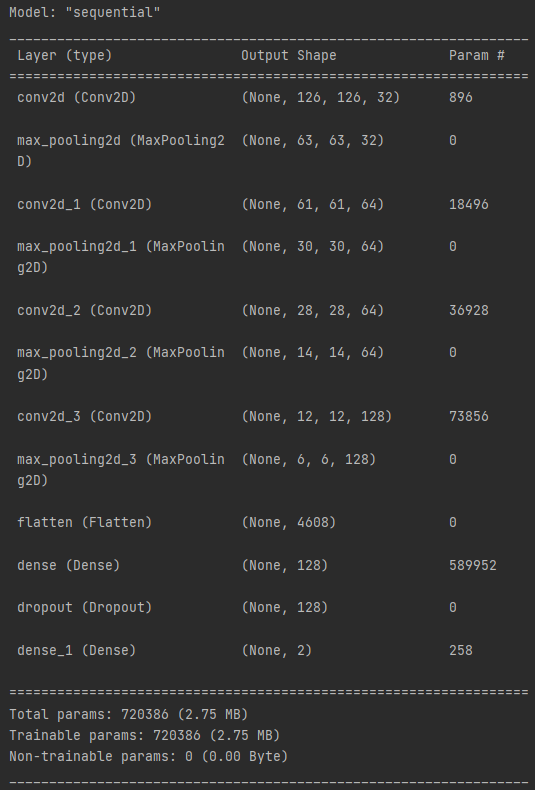

### Install *pydot* and *graphviz* ###

After building the model, we use ‘plot_model’ to generate the model architecture graph. We import ‘plot_model’ from Keras’ ‘utils’ module. The ‘to_file’ argument specifies the filename where the graph will be saved (in this case, as “model_architecture.png”). The ‘show_shapes=True’ and ‘show_layer_names=True’ arguments ensure that the shapes of each layer and their names are displayed in the graph.



In [7]:
##!pip install pydot
##!pip install graphviz

from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


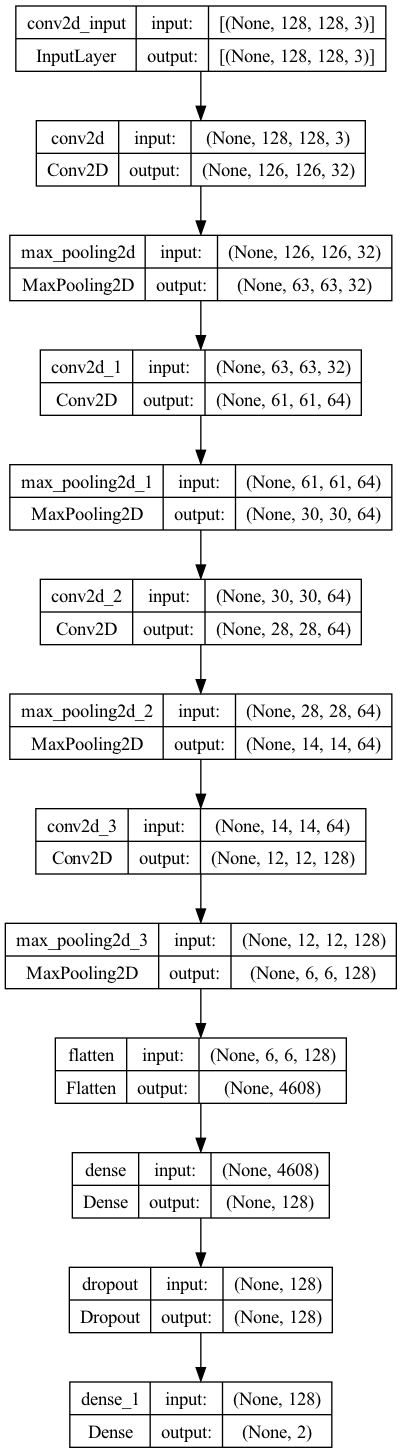

After running this code, you should also find a file named “model_architecture.png” (pictured above) in the working directory, which contains the visualization of the model architecture graph. This graph provides insights into the model’s structure and the flow of data through different layers.

!pip install visualkeras

import visualkeras
visualkeras.layered_view(model)

### Step 5: Train the model and save the best model based on validation accuracy ###

We use the ‘ModelCheckpoint’ to save the best model during the training process based on the validation accuracy. The ‘model.fit’ function performs the training process and stores the training history in the 'history' variable.

In [ ]:
import scipy

# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint("best_cnn_mask_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/50


2023-10-06 17:36:07.369148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7644
Epoch 1: val_accuracy improved from -inf to 0.91241, saving model to best_cnn_mask_model.h5
21/21 [==============================] - 13s 381ms/step - loss: 0.4475 - accuracy: 0.7644 - val_loss: 0.1836 - val_accuracy: 0.9124
Epoch 2/50


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9282
Epoch 2: val_accuracy improved from 0.91241 to 0.94891, saving model to best_cnn_mask_model.h5
21/21 [==============================] - 6s 267ms/step - loss: 0.2153 - accuracy: 0.9282 - val_loss: 0.1204 - val_accuracy: 0.9489
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9470
Epoch 3: val_accuracy improved from 0.94891 to 0.97080, saving model to best_cnn_mask_model.h5
21/21 [==============================] - 6s 263ms/step - loss: 0.1672 - accuracy: 0.9470 - val_loss: 0.0821 - val_accuracy: 0.9708
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9548
Epoch 4: val_accuracy did not improve from 0.97080
21/21 [==============================] - 6s 264ms/step - loss: 0.1116 - accuracy: 0.9548 - val_loss: 0.0974 - val_accuracy: 0.9562
Epoch 5/50
21/21 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9704
E

### Step 6: Plot the training and validation loss and accuracy to visualize the training progress ###
Plot the training and validation loss as well as the training and validation accuracy of a CNN model during the training process. This visualization is crucial for understanding the model’s performance and monitoring its training progress.

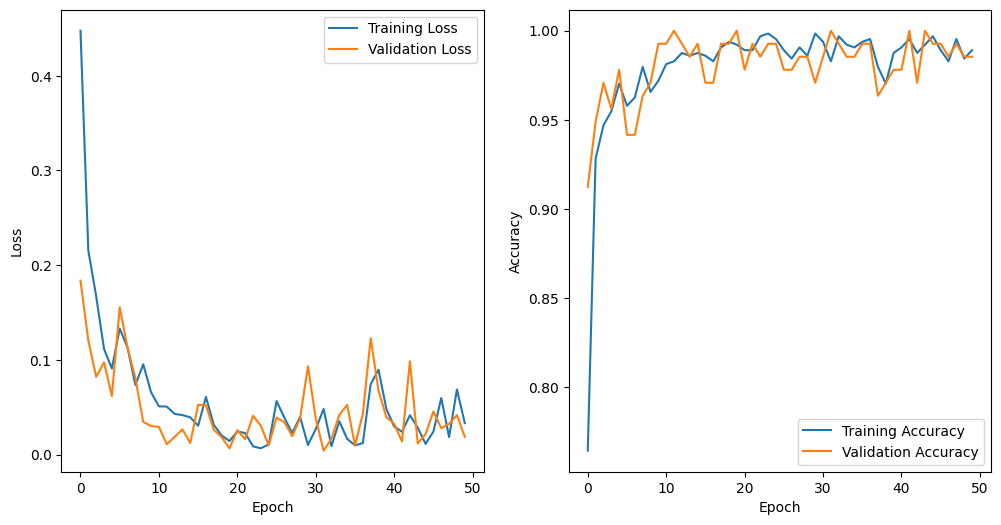

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


These graphs that show the training and validation loss/accuracy help provide insights into the training process. These insights help make informed decisions regarding the architecture of the model, hyperparameter tuning, and early stopping, which ensures the best performance from the CNN model.

### Step 7: Test the model on the test set and display some sample images ###
Load the best model based on the validation accuracy saved during training using the ModelCheckpoint. We then use the test data generator to get the test samples and display some sample images along with their true and predicted labels.

139/139 [==============================] - 1s 6ms/step


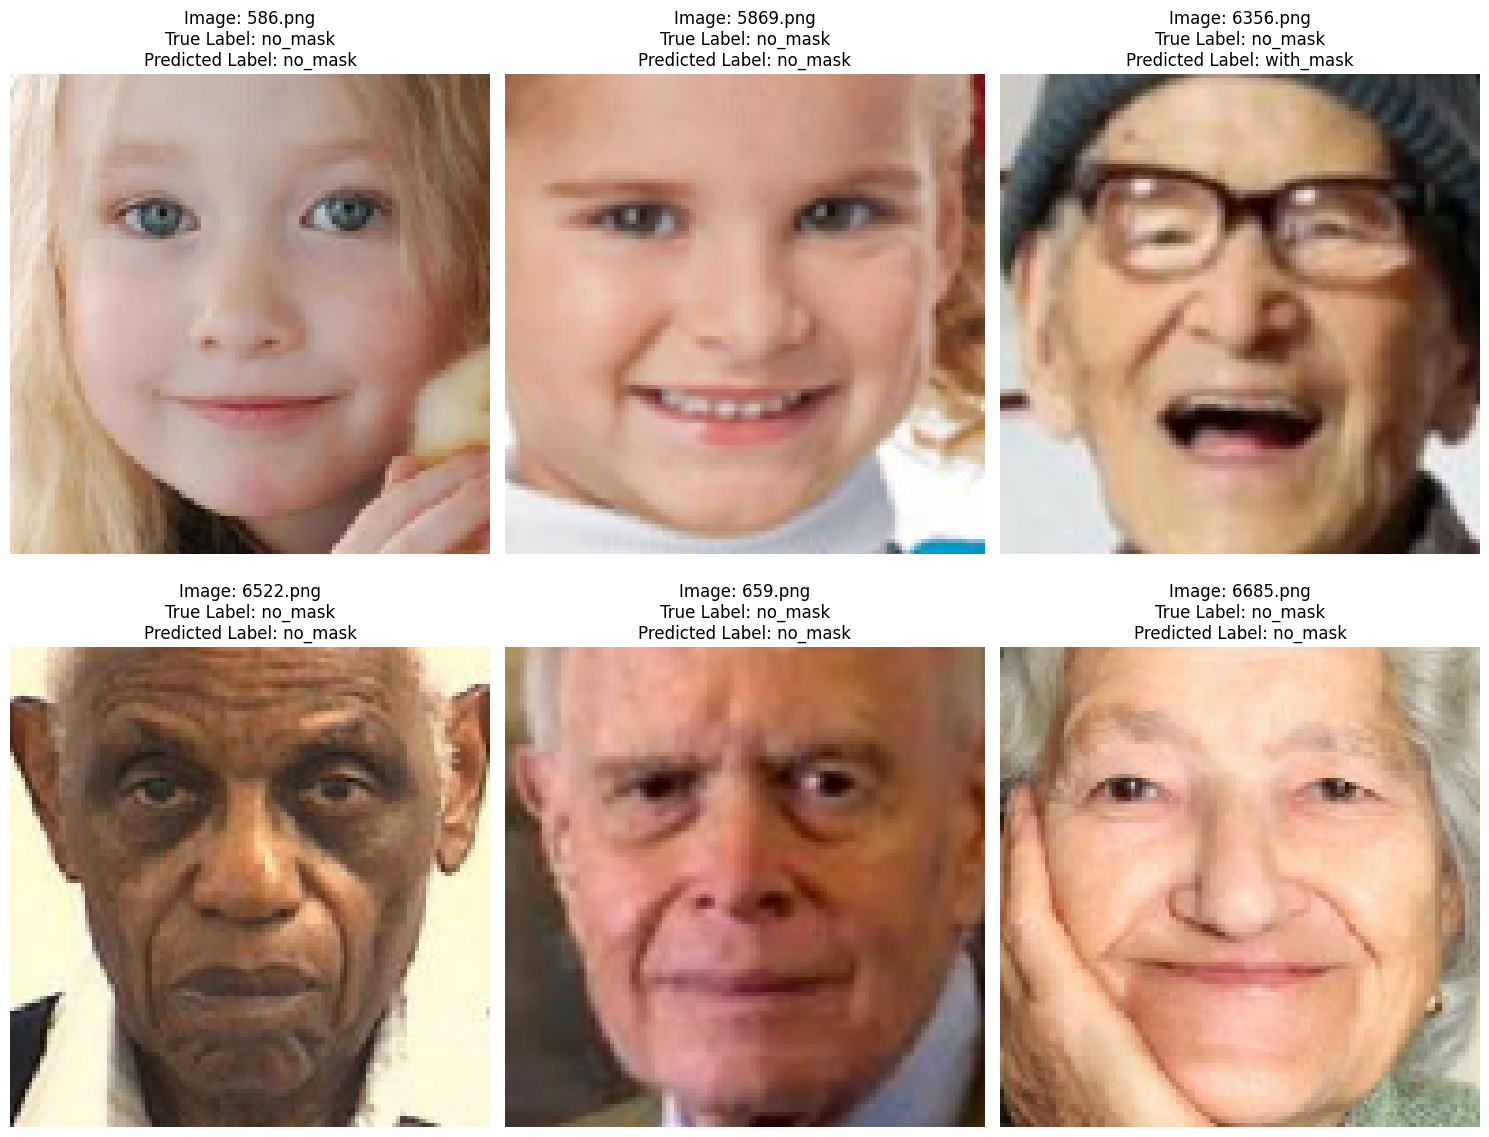

In [ ]:
# Predict on the test set
predictions = model.predict(test_generator)

# Display some sample images from the test set along with their true and predicted labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, true_label = test_generator.next()
    img_filename = test_generator.filenames[test_generator.batch_index - 1]  # Get the filename of the current image
    true_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_label.argmax())]  # Get the true class name
    predicted_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predictions[i].argmax())]  # Get the predicted class name

    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nTrue Label: {true_class}\nPredicted Label: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 8: Evaluate the model on the test set ###
To evaluate the trained CNN model on the test set and obtain the test loss and accuracy, we can use the ‘test_generator’ created with ‘ImageDataGenerator’.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

139/139 [==============================] - 2s 12ms/step - loss: 0.0472 - accuracy: 0.9712
Test Loss: 0.0472
Test Accuracy: 0.9712


After loading trained model and the best weights using load_weights, we use evaluate to obtain the test loss and accuracy. These values are printed to the console. The evaluation results show that the test loss is 4.72% and the test accuracy is 97.12%.

### Step 9: Model deployment ###

Model deployment is a critical step in the machine learning lifecycle, as it allows the model to be utilized in real-world scenarios and provide value to end-users. Proper deployment practices help deliver the benefits of machine learning and artificial intelligence to a wide range of applications and industries.

In the above code, we load and preprocess an image using TensorFlow and making a prediction with the trained model. It correctly loads the image from the local drive, resizes it to the desired dimensions, converts it to a NumPy array, and adds a batch dimension.

Here’s a summary of the steps:

* Load the best model saved during training using ‘load_model()’ from Keras.
* Download an image from a URL using ‘tf.keras.utils.get_file()’. The ‘origin’ argument should be the URL of the image you want to download.
* Load and preprocess the image using ‘tf.keras.utils.load_img()’ and ‘tf.keras.utils.img_to_array()’.
* Add a batch dimension to the image using ‘tf.expand_dims()’ to match the expected input shape of the model.
* Make predictions using the ‘model.predict()’ method.
* Apply ‘tf.nn.softmax()’ function to the predicted scores. This function converts the scores into probabilities, representing the confidence of the model’s predictions.
* Use the ‘np.argmax(score)’ function to find the index of the class with the highest probability (the predicted label), and ‘class_names[np.argmax(score)]’ retrieves the corresponding class name list [‘daisy’, ‘dandelion’, ‘rose’, ‘sunflower’, ‘tulip’].
* Calculate the percent confidence of the predicted class using ‘100 * np.max(score)’ , and format the value to two decimal places using ‘:.2f’ in the print statement.

Since the images are stored in folders on the local drive, we use the local path of the images to be predicted.

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

img_height = 128
img_width = 128

# Load the best model saved during training
model = load_model("./best_cnn_mask_model.h5")

# Load and preprocess the image
image_path = "./mask_split_data/test/with_mask/19.png"

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['with_mask','no_mask']

print(
    "This image most likely belongs to {} with a {:.2f} % confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 77ms/step
This image most likely belongs to no_mask with a 73.11 % confidence.


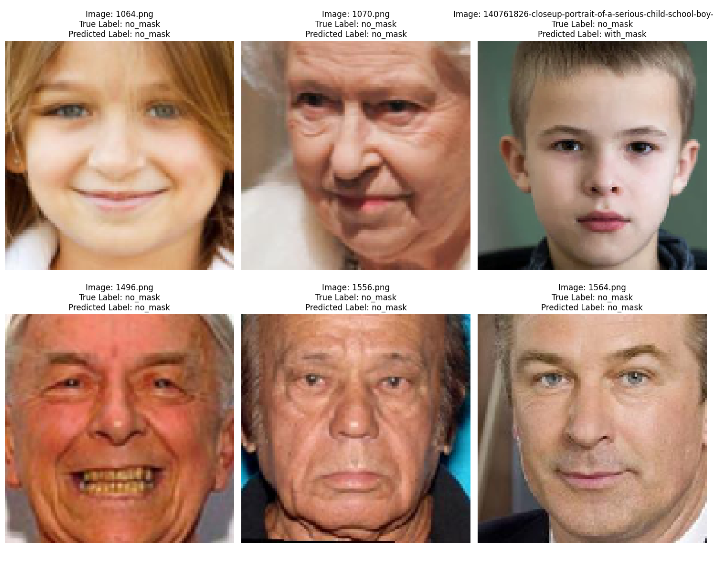

<h2>Analysis of our Findings</h2>

As shown in the picture above, our model correctly predicted 5 out of the 6 images correctly with a 73.11% confidence. While this confidence percentage could be considered decent, in a practical application, it may not be deemed sufficient, especially those where accuracy is critical to public safety.

Another thing that we noticed about the testing of our CNN is that it only showed images of people not wearing a mask (images from the no_mask dataset), which leads us to believe that the images selected to test the CNN were not as random as we were intending it to be.

<h2>References</h2>

- ChatGPT
- CS courses (Padlet)